<div style="text-align:center">
    <h1>Rapport du projet</h1>
</div>


<h2><strong>Réalisé par:</strong></h2>
<ul>
    <li style="list-style-type:disc">ALAHYANE Nour-eddine</li>
    <li style="list-style-type:disc">LAAROUCHI Ayoub</li>
</ul>
<h2>Introduction</h2>
<p>     Ce projet a pour but d'appliquer la méthode de Box-Jenkins sur une série temporelle, notre choix a tombé sur une série chornologique illustrant la production de l'électricité de l'électricité mensuellement sur une période qui s'étend entre 1985 et 2018.</p>


### 1.Récupérer le fichier des données Sur R/Python.

<p>     On utilise la bibliothèque pandas pour créer une dataframe à partir du fichier Electric_Production.csv qui contient deux colonnes 'date' qui signifie la date de l'enregistrement et 'production' qui signifie  la quantité de l'énergie éléctrique produite. </p>

In [88]:
#Récupération des données

import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

data = pd.read_csv('Electric_Production.csv')
data.rename(columns={'DATE':'date','IPG2211A2N':'production'},inplace=True)
data

,date,production
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151
...,...,...
392,9/1/2017,98.6154
393,10/1/2017,93.6137
394,11/1/2017,97.3359
395,12/1/2017,114.7212


### 2.Diviser les données

<p>On divise le data set en deux parties, 25% pour le test et 75% pour l’apprentissage.</p>

In [89]:
#Transformation de la colonne des dates en type 'datetime'
data['date'] = pd.to_datetime(data['date'])
data.set_index('date' ,inplace=True)

df_test = data[['production']].iloc[300:]
df_train = data[[ 'production']].iloc[:299]

### 3.Représenter graphiquement la série.

<Axes: xlabel='date'>

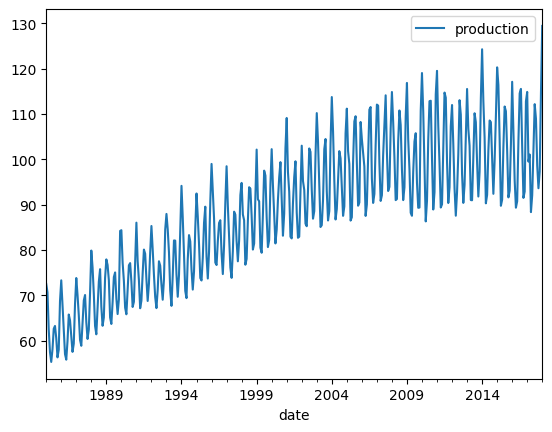

In [90]:

#Visualisation de la série temporelle

data[['production']].plot()

### 4.Repérer d’éventuelles tendances et/ou saisonnalités.

<p>Vu que le traçage directe de la série temporelle ne donne pas assez d'information sur sa tendance voir la saisonnalité, on doit appliquer ce qu'on appelle la décomposition des séries temporelles qui consiste à séparer une série temporelle observée en différentes composantes (tendance, saisonalité et composante résiduelle).</p>

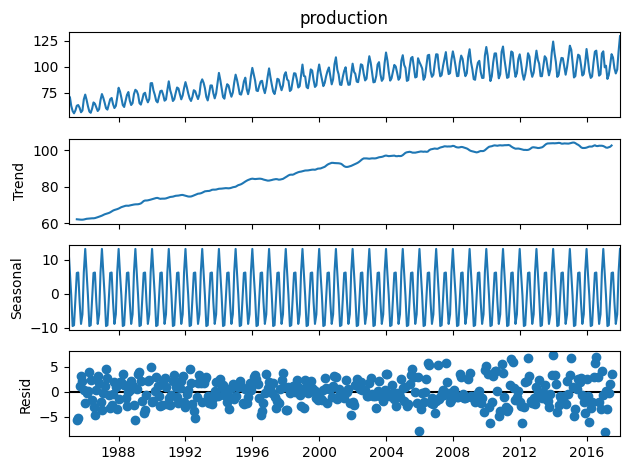

In [91]:
#Décomposition de la série temporelle pour une meilleure visualisation des données

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(x=data['production'],model='additive',period=12)
decomposition.plot()
plt.show()


<p>D'après ces observations on remarque que cette série temporelle suit une tendance croissante elle est donc considérée non stationnaire. Allors ses propriétés statistiques ne sont pas constantes dans le temps (espérance, variance ...).</p>

### 5.Tracer et Analyser les corrélogrammes simple et partiel

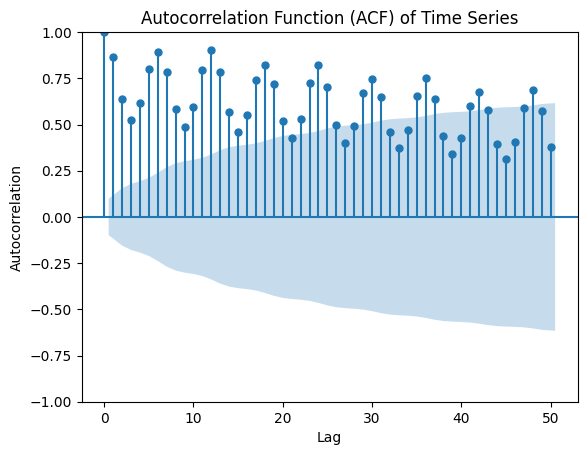

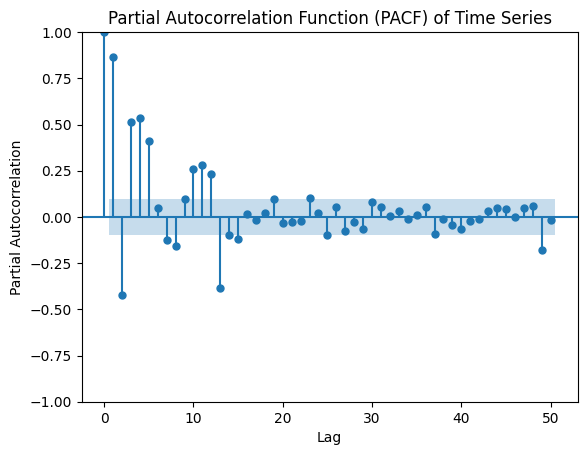

In [92]:
##Plot ACF & PACF

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Plotting the ACF
plot_acf(data['production'],lags = 50)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) of Time Series')
plt.show()


# Plotting the PACF
plot_pacf(data['production'], lags = 50)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF) of Time Series')
plt.show()

<p>D'après les graphes de PACF et ACF on peut déduire l'ordre des modèles AR, MA et ARMA: 

-le graphe de PACF montre 3 retards qui sont significatifs, on peut donc dire que cette serie est un processus AR(3).

-le graphe de ACF montre 2 retards qui sont significatifs , on peut donc dire que cette serie est un processus MA(2).

<strong>Important:</strong> les tracés ACF et PACF constituent un bon point de départ pour déterminer le processus et les termes AR et MA. Cependant, le nombre de termes à inclure dans le modèle final doit être déterminé après avoir pris en compte d'autres facteurs (AIC et BIC).</p>

<p>l'établissement de la saisonnalité va rendre les donées plus faciles à être prévisibles. Cela permet aux modèles de mieux capturer les relations entre les variables et d'améliorer la précision des prédictions.</p>

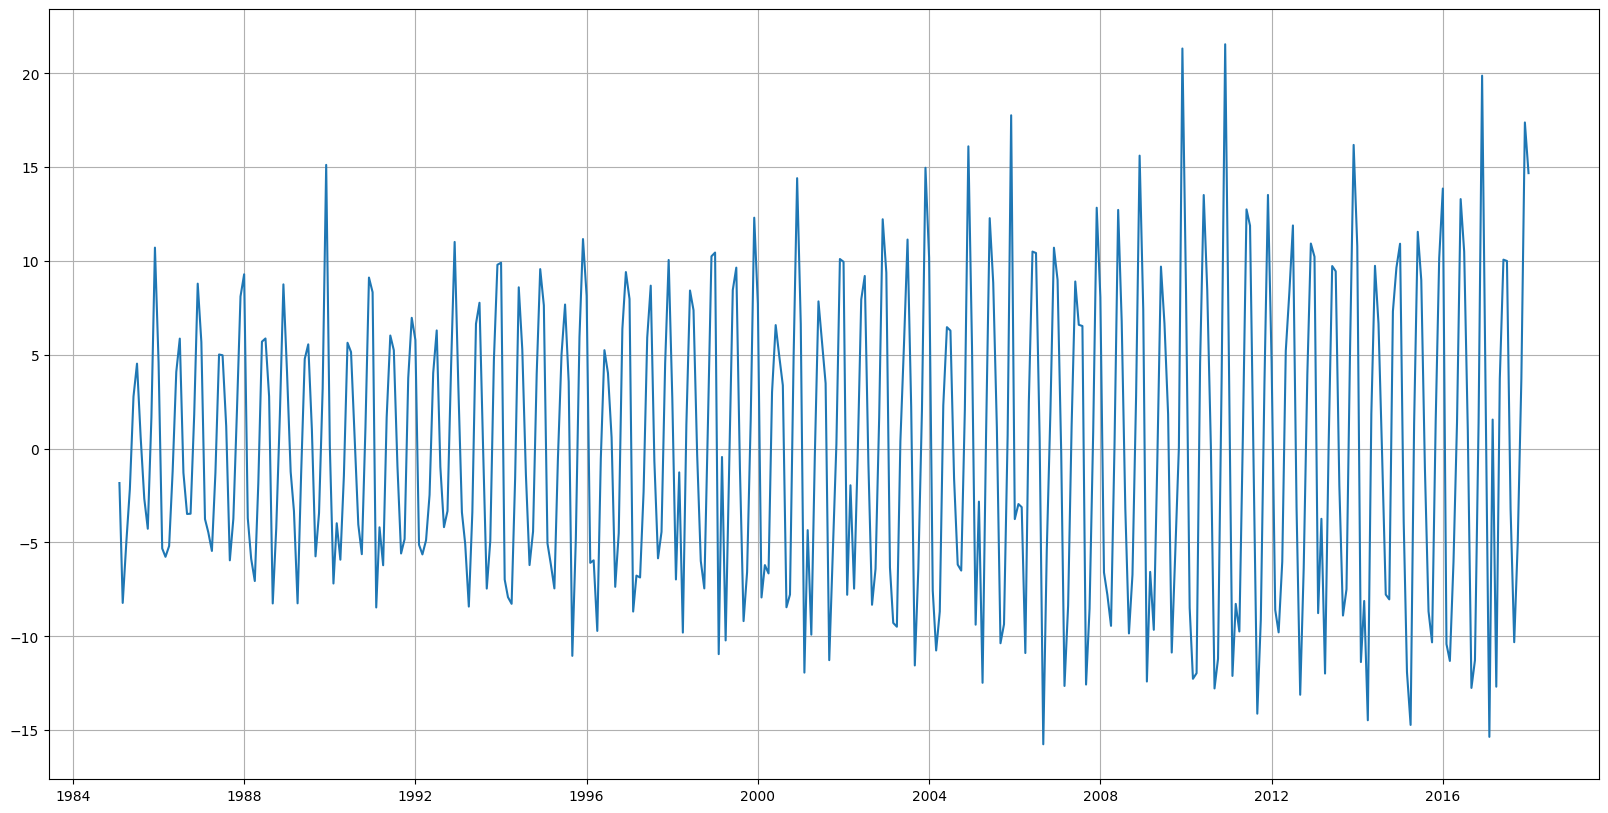

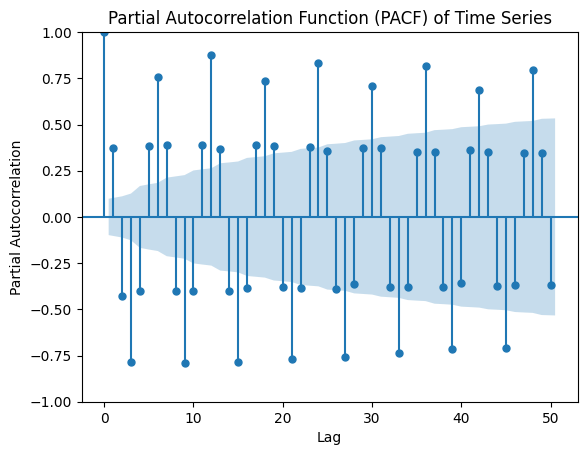

In [93]:
#La méthode de différenciation pour rendre la série temporelle stationnaire
diff = data['production']-data['production'].shift(1)
diff = diff.dropna(inplace = False)
#Visualisation de la série après élimination de la tendance
plt.figure(figsize=(20, 10))
plt.plot(data.iloc[1:].index, diff)
plt.grid()
plt.show()
#ACF après la stationnarité
plot_acf(diff, lags = 50)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF) of Time Series')
plt.show()



<p>La raison pour laquelle nous souhaitons supprimer la saisonnalité est de rendre notre série chronologique stationnaire, ce qui est une exigence de la plupart des modèles de prévision comme ARIMA.</p>

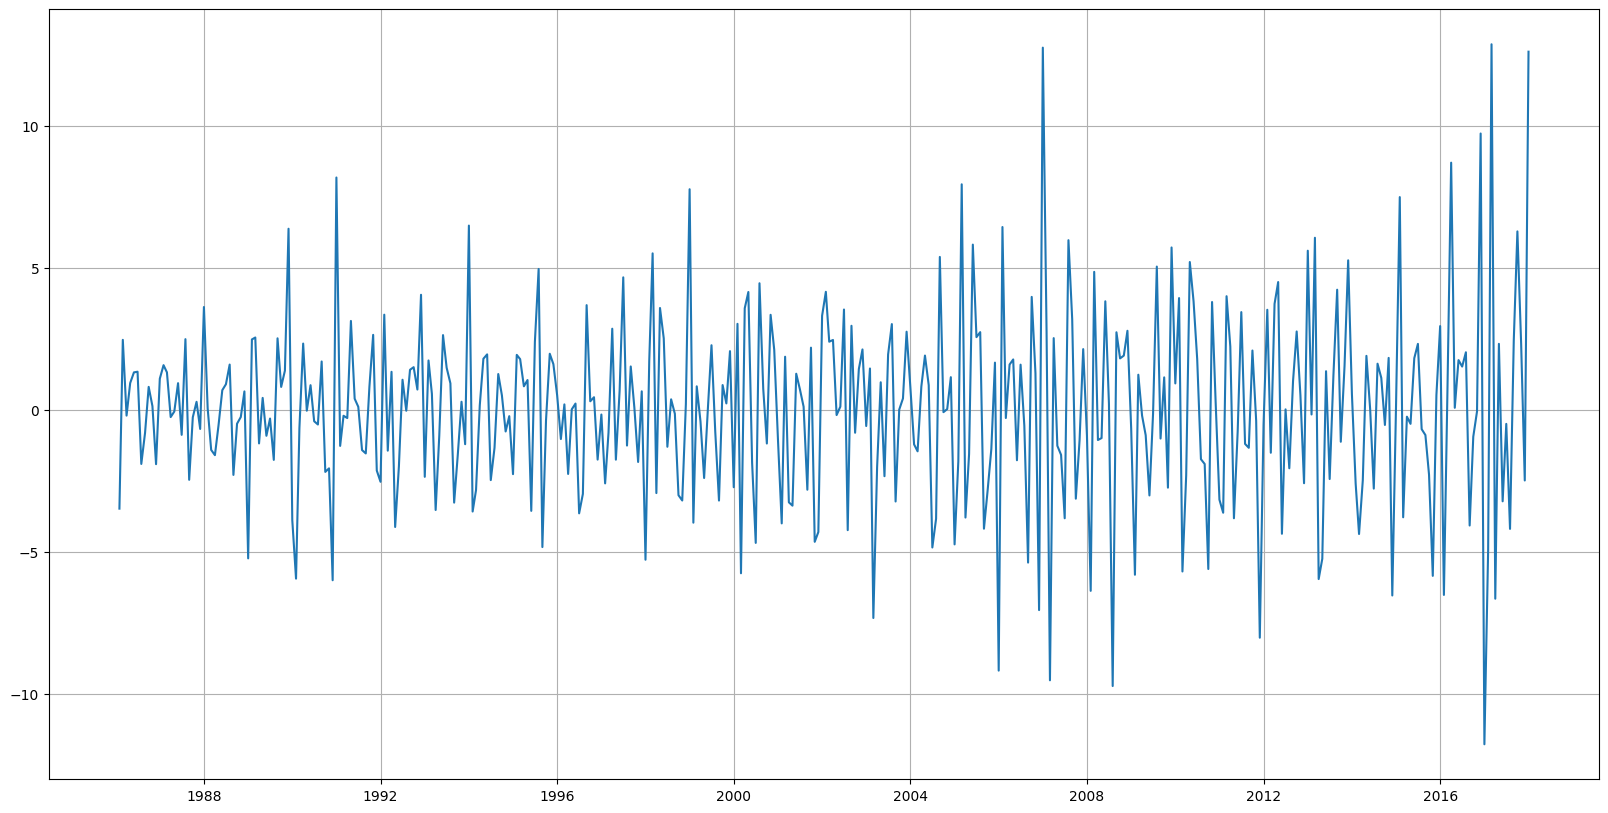

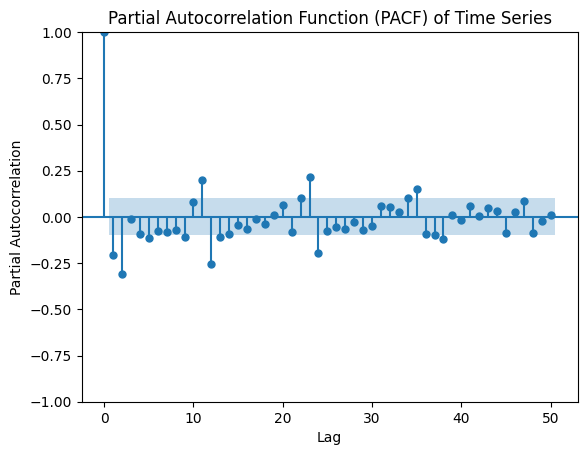

In [94]:
#Elimination de la saisonalité (les 12 premiers jours de chaque mois)

diff = data['production']-data['production'].shift(1)
diff_season = diff - diff.shift(12)
diff_season = diff_season.dropna(inplace=False)
#Visualisation de la série après élimination de la saisonalité
plt.figure(figsize=(20, 10))
plt.plot(data.iloc[13:].index, diff_season)
plt.grid()
plt.show()
#PACF après l'élimination de la saisonnalité

plot_pacf(diff_season, lags = 50)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF) of Time Series')
plt.show()


<p>Ici, nous comparerons les critères d'information pour ARIMA(3,1,4), ARIMA(3,1,3) ,ARIMA(2,1,3) et ARIMA(2,1,4) et leurs résultats. Nous devons estimer chaque modèle ARIMA et les critères d'information pour chaque modèle. Après comparaison, nous choisissons le modèle avec la valeur d'AIC ou de BIC la plus faible pour une analyse plus approfondie telle que la prévision.</p>

<p><strong>Source:</strong> <a href = 'https://spureconomics.com/information-criteria-aic-sic-and-model-selection/'>https://spureconomics.com/information-criteria-aic-sic-and-model-selection/</a></p>

In [95]:
#création du modèle

from statsmodels.tsa.arima.model import ARIMA
L = [(3,1,4), (3,1,3), (2,1,3), (2,1,4)]
T = []
for i in range (len(L)):
    arima_model = ARIMA(df_train['production'],order=L[i]).fit()
    T.append(( f"AIC pour ARIMA{L[i]}: {arima_model.aic}", f"BIC pour ARIMA{L[i]}: {arima_model.bic}"))


/home/noureddine/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/noureddine/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/noureddine/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


/home/noureddine/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/noureddine/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/noureddine/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/noureddine/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/noureddine/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likel

In [96]:
print(T)

[('AIC pour ARIMA(3, 1, 4): 1528.2426938975054', 'BIC pour ARIMA(3, 1, 4): 1557.8194417895486'), ('AIC pour ARIMA(3, 1, 3): 1538.3197560155882', 'BIC pour ARIMA(3, 1, 3): 1564.199410421126'), ('AIC pour ARIMA(2, 1, 3): 1531.8338210883326', 'BIC pour ARIMA(2, 1, 3): 1554.0163820073649'), ('AIC pour ARIMA(2, 1, 4): 1514.682827109295', 'BIC pour ARIMA(2, 1, 4): 1540.5624815148328')]


<p>D'après les résultats obtenus on remarque que ARIMA(2, 1, 4) est celui qui a les coefficients AIC et BIC les plus faibles donc il va être le meilleur choix pour la prévision</p>

/home/noureddine/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/noureddine/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/noureddine/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


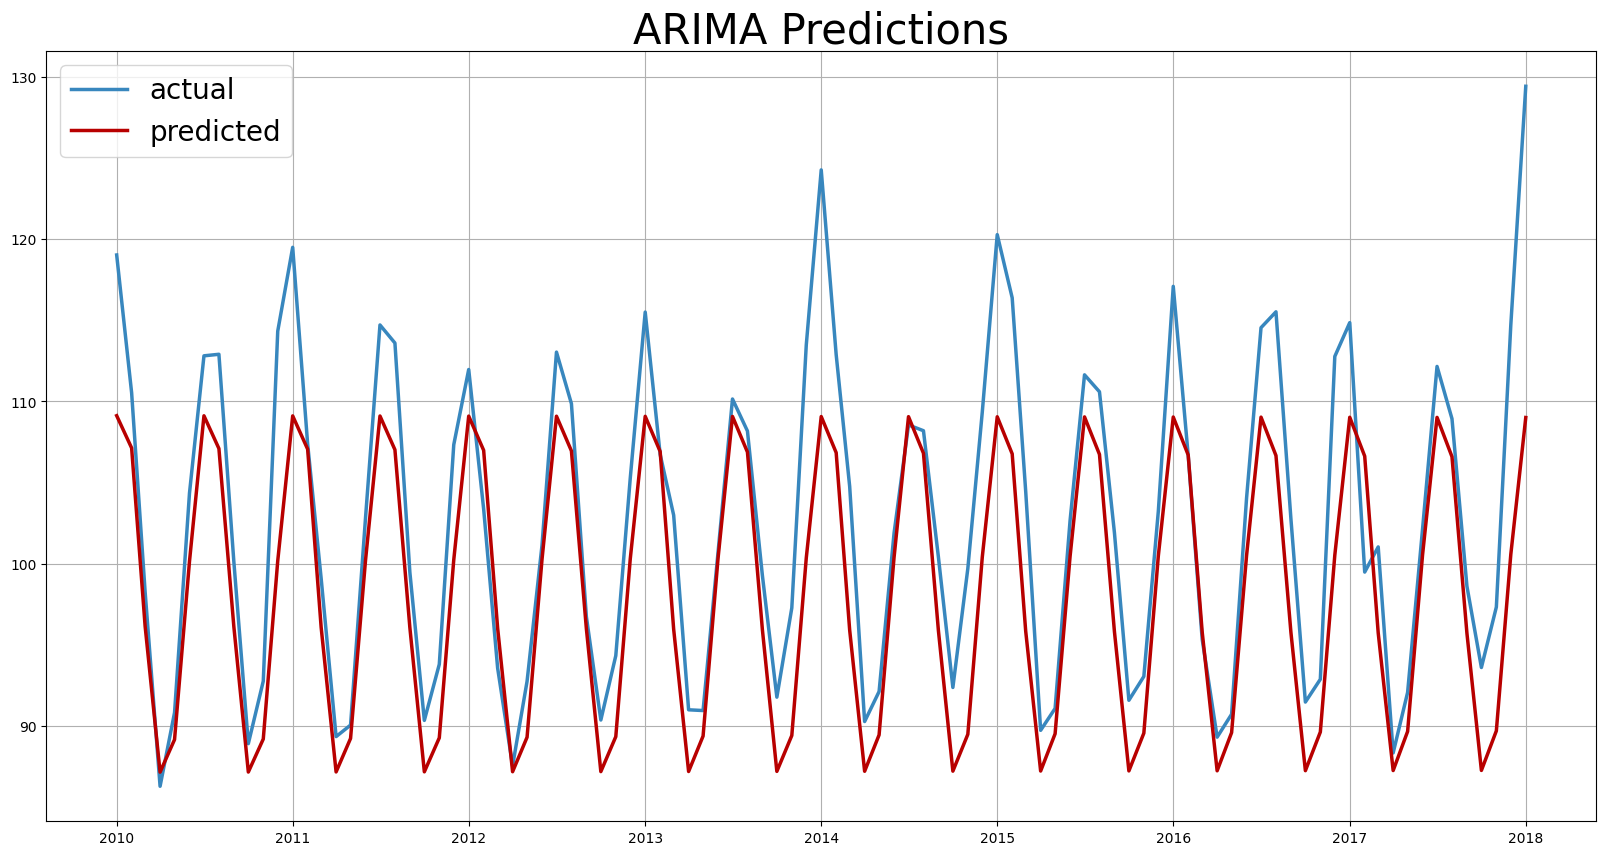

In [97]:
arima_model = ARIMA(df_train['production'],order=(2,1,4)).fit()
# generate predictions
df_pred = arima_model.predict(start= 300 , end= 396)
# plot actual vs. predicted
fig = plt.figure(figsize=(20, 10))
plt.title('ARIMA Predictions', fontsize=30)
plt.plot(df_test['production'], label='actual', color='#3887BE', linewidth = 2.5)
plt.plot(df_pred, label='predicted', color='#B80000', linewidth = 2.5)
plt.legend(fontsize =20, loc='upper left')
plt.grid()

### 8.Evaluer les prévisions obtenues 

In [98]:
from sklearn.metrics import mean_squared_error
from math import sqrt
print(arima_model.summary())

rmse = sqrt(mean_squared_error(df_test['production'], df_pred))
print("RMSE:", round(rmse,2))
print('Une large valeur entre RMSE signifie une grande diffèrence entre les valeurs actuelles et les valeurs prédites.')



                               SARIMAX Results                                
Dep. Variable:             production   No. Observations:                  299
Model:                 ARIMA(2, 1, 4)   Log Likelihood                -750.341
Date:                Tue, 19 Dec 2023   AIC                           1514.683
Time:                        23:43:18   BIC                           1540.562
Sample:                    01-01-1985   HQIC                          1525.042
                         - 11-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9989      0.003    345.384      0.000       0.993       1.005
ar.L2         -0.9995      0.001   -824.697      0.000      -1.002      -0.997
ma.L1         -1.2890      0.051    -25.364      0.0